# Data Preprocessing and Exploratory Analysis


### <span style="color: red">Warning</span>

This version has outdated proportion results. Please refer to `dataIntegrity` inside `matlabComparison` for correct values.

This notebook documents the essential normalization, quality assessment and general preprocessing and analysis steps of the created dataframe.

Initial ideas consist of:

 - Hounsfield Units Manual Normalization
 - Class Imbalance Identification (maintain data ratio on augmentation or aim for 50/50?)
 - Investigate new, possibly more meaningful metrics
 - General EDA

The core objective of this notebook is to build a clean, augmented dataframe and export it to a `.pkl` file. The file will be used to compare augmentation performance. I assume this `.ipynb` file can possibly be reused (needs only changes on solutions due to observed issues) with the 3d dataset.

In [2]:
# Relevant imports

import os
import pandas as pd
import pickle
import random
import pydicom
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
import seaborn as sns

In [3]:
# Pulling dataframe 

#df_fibrosis = pd.read_pickle(r'D:\\Rafa\\A1Uni\\2semestre\\Estágio\\fibrosis_data.pkl')

#df_fibrosis = pd.read_pickle(r'C:\\Users\\hasht\Desktop\\fibrosis_data.pkl')

df_fibrosis = pd.read_pickle(r'..\..\\fibrosis_data.pkl')
df_fibrosis.head(10)

,SliceID,SliceData,Class
0,101__CT-0002-0001,"[[-2000.0, -2000.0, -2000.0, -2000.0, -2000.0,...",0
1,101__CT-0002-0002,"[[-2000.0, -2000.0, -2000.0, -2000.0, -2000.0,...",0
2,101__CT-0002-0003,"[[-2000.0, -2000.0, -2000.0, -2000.0, -2000.0,...",0
3,101__CT-0002-0004,"[[-2000.0, -2000.0, -2000.0, -2000.0, -2000.0,...",0
4,101__CT-0002-0005,"[[-2000.0, -2000.0, -2000.0, -2000.0, -2000.0,...",0
5,101__CT-0002-0006,"[[-2000.0, -2000.0, -2000.0, -2000.0, -2000.0,...",1
6,101__CT-0002-0007,"[[-2000.0, -2000.0, -2000.0, -2000.0, -2000.0,...",0
7,101__CT-0002-0008,"[[-2000.0, -2000.0, -2000.0, -2000.0, -2000.0,...",1
8,101__CT-0002-0009,"[[-2000.0, -2000.0, -2000.0, -2000.0, -2000.0,...",0
9,101__CT-0002-0010,"[[-2000.0, -2000.0, -2000.0, -2000.0, -2000.0,...",0


# Preliminary Analysis

I won't be performing any type of specific statystical analysis here, since features will be derived by CNN. Instead, I will be focusing on normalization and augmentation, with the intent of enhancing algortihm performance.

In [4]:
# General overview
print("\nGeneral overview:")
df_fibrosis.info()


General overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3074 entries, 0 to 3073
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   SliceID    3074 non-null   object
 1   SliceData  3074 non-null   object
 2   Class      3074 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 72.2+ KB


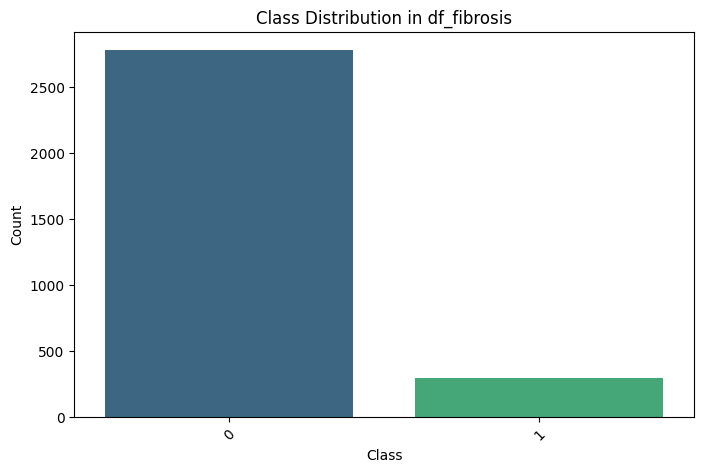

Class
0    90.403383
1     9.596617
Name: count, dtype: float64


In [5]:
# Plots class counts
plt.figure(figsize=(8, 5))
sns.countplot(data=df_fibrosis, x='Class', hue="Class", palette='viridis', legend=False)

plt.title('Class Distribution in df_fibrosis')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=45)  
plt.show()


# Displays imbalance
class_counts, total_samples = df_fibrosis['Class'].value_counts(), len(df_fibrosis)
print((class_counts / total_samples) * 100)

It is also important to verify if the predefined test split shares the same data proportion, for result validity:

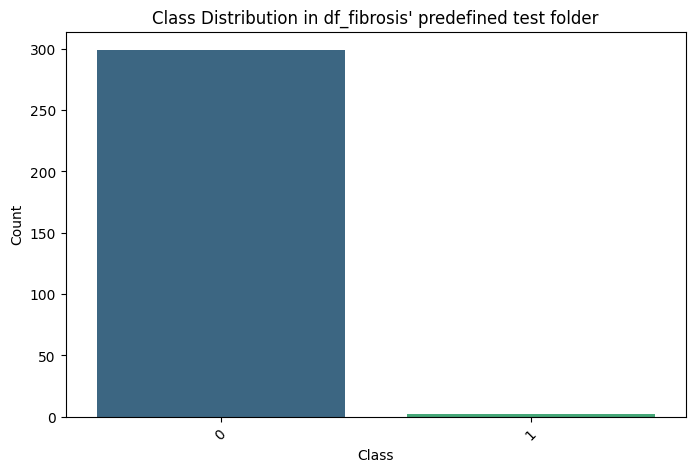

Class
0    99.335548
1     0.664452
Name: count, dtype: float64


In [6]:
df_fibrosis_test = df_fibrosis[df_fibrosis["SliceID"].str.contains("HRCT_Pilot")]

# Plots class counts
plt.figure(figsize=(8, 5))
sns.countplot(data=df_fibrosis_test, x='Class', hue="Class", palette='viridis', legend=False)

plt.title('Class Distribution in df_fibrosis\' predefined test folder')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=45)  
plt.show()


# Displays imbalance
class_counts, total_samples = df_fibrosis_test['Class'].value_counts(), len(df_fibrosis_test)
print((class_counts / total_samples) * 100)

After identifying the drastic class imbalance, I am faced with a dillema. I am already planning on applying data augmentation, so my options are:

 - **Equalizing or approximating proportions:** this would provide the model with roughly the same ammount of `fibrosis` vs `not_fibrosis` data. The issue is that I would be artifically affecting the natural proportion of fibrosis found in the study's population, as well as introducing a much higher portion of augmented data as `fibrosis` slices when compared to `not_fibrosis`.

 - **Keeping proportions:** this would ensure the correct representation of the study's population, maintaining potentially relevant data relationships. However, the model could be biased towards the majority class (`not_fibrosis`), or be much better at its detection when compared to `fibrosis`, due to the significantly reduced number of examples.


In order to respect data integrity, I decided to apply augmentation while keeping proportions. As a way to correctly evaluate performance, weighted metrics will be employed after model training.

Aditionally, due to different class imbalances and the overwhelming class 0 size, I must take into consideration separate accuracies when evaluating performance. Classification when fibrosis is present is going to be quite challenging!